# Explication des cellules d'initialisation
Nous avons testé plusieurs approches : en local, avec Pycharm. Dans le cloud, avec Kaggle & Google Colab.
Nous avons donc mis en place plusieurs configurations pour chaque environnement.
Si local, vérifier que java 11 est bien installé. Si Kaggle, uploader le csv comme dataset afin de l'avoir à disposition.


In [115]:
import time
from pyspark.sql import SparkSession
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql.functions import col, when, avg, max, min, count, row_number, split, explode, trim
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

In [74]:
file_path_csv = "/kaggle/input/openfoodfacts/en.openfoodfacts.org.products.csv"
file_path_parquet = "/kaggle/working/en.openfoodfacts.org.products.parquet"

In [75]:
file_path_csv = "./data/en.openfoodfacts.org.products.csv"
file_path_parquet = "./data/en.openfoodfacts.org.products.parquet"
file_save_path = "./data/saved.parquet"

In [71]:
#database configuration
url = "jdbc:mysql://localhost:3306/openfood_db"
properties = {
    "user": "root",
    "password": "root",
    "driver": "com.mysql.cj.jdbc.Driver"
}

In [16]:
start_time = time.time()
print("Démarrage du script...")

# Initialiser une SparkSession avec des logs réduits
spark = SparkSession.builder \
    .appName("Exploration OpenFoodFacts") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")  # Réduction des logs

print("PySpark chargé")

try:
    # Charger le fichier CSV en tant que DataFrame Spark puis échantillonne 20%
    df_csv_before_sample = spark.read.csv(file_path_csv, header=True, inferSchema=True, sep="\t")
    print("Fichier CSV chargé.")
    df_csv = df_csv_before_sample.sample(withReplacement=False, fraction=0.2)  # Échantillonnage à 20%
    print("Echantillonage terminé")

    # Sauvegarder le DataFrame au format Parquet
    df_csv.write.parquet(file_path_parquet, mode="overwrite")
    print("Données sauvegardées au format Parquet.")

    # Charger le fichier Parquet pour une analyse future
    df_parquet = spark.read.parquet(file_path_parquet)
    print("Fichier Parquet chargé.")

    # Vérifier et supprimer l'ancienne table Hive
    table_name = "hive_table"
    hive_table_path = f"spark-warehouse/{table_name}"
    if table_name in [t.name for t in spark.catalog.listTables("default")]:
        print(f"La table '{table_name}' existe déjà et doit être supprimé.")
        spark.sql(f"DROP TABLE {table_name}")
        print(f"Table Hive '{table_name}' supprimée.")
    if os.path.exists(hive_table_path):
        shutil.rmtree(hive_table_path)
        print(f"Répertoire associé '{hive_table_path}' supprimé.")

    # Création de la table Hive
    print("Création et insertion dans la table Hive...")
    hive_table_start_time = time.time()
    df_csv.write.mode("overwrite").saveAsTable("hive_table")

except Exception as e:
    print(f"Erreur rencontrée : {e}")

finally:
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Temps d'exécution : {elapsed_time:.2f} secondes")


Démarrage du script...
PySpark chargé


Fichier CSV chargé.
Echantillonage terminé


Données sauvegardées au format Parquet.
Fichier Parquet chargé.
La table 'hive_table' existe déjà et doit être supprimé.
Table Hive 'hive_table' supprimée.
Création et insertion dans la table Hive...


Temps d'exécution : 120.02 secondes


In [17]:
# Mesure du temps pour compter les lignes du DataFrame CSV
csv_start_time = time.time()
csv_row_count = df_csv.count()  # Compter les lignes
csv_end_time = time.time()
csv_elapsed_time_ms = (csv_end_time - csv_start_time) * 1000
print(f"CSV (comptage des lignes): {csv_elapsed_time_ms:.3f} ms - Nombre de lignes: {csv_row_count}")

# Mesure du temps pour compter les lignes du DataFrame Parquet
parquet_start_time = time.time()
parquet_row_count = df_parquet.count()  # Compter les lignes
parquet_end_time = time.time()
parquet_elapsed_time_ms = (parquet_end_time - parquet_start_time) * 1000
print(f"Parquet (comptage des lignes): {parquet_elapsed_time_ms:.3f} ms - Nombre de lignes: {parquet_row_count}")

# Mesure du temps pour compter les lignes de la table Hive
hive_start_time = time.time()
df_hive = spark.sql("SELECT * FROM hive_table")  # Charger la table Hive
hive_row_count = df_hive.count()  # Compter les lignes
hive_end_time = time.time()
hive_elapsed_time_ms = (hive_end_time - hive_start_time) * 1000
print(f"Hive (comptage des lignes): {hive_elapsed_time_ms:.3f} ms - Nombre de lignes: {hive_row_count}")

# Comparaison des temps
print("\nComparaison des performances :")
print(f"CSV Execution Time: {csv_elapsed_time_ms:.3f} ms")
print(f"Parquet Execution Time: {parquet_elapsed_time_ms:.3f} ms")
print(f"Hive Execution Time: {hive_elapsed_time_ms:.3f} ms")

CSV (comptage des lignes): 11304.040 ms - Nombre de lignes: 703562
Parquet (comptage des lignes): 215.001 ms - Nombre de lignes: 703562
Hive (comptage des lignes): 211.825 ms - Nombre de lignes: 703562

Comparaison des performances :
CSV Execution Time: 11304.040 ms
Parquet Execution Time: 215.001 ms
Hive Execution Time: 211.825 ms


# Analyse préliminaire
### 1. Mise en valeur des lignes, colonnes



In [18]:
# Mesure du temps pour compter les lignes du DataFrame CSV
csv_start_time = time.time()
csv_row_count = df_csv.count()
csv_end_time = time.time()
csv_elapsed_time_ms = (csv_end_time - csv_start_time) * 1000
print(f"CSV (comptage des lignes): {csv_elapsed_time_ms:.3f} ms - Nombre de lignes: {csv_row_count}")

# Mesure du temps pour compter les lignes du DataFrame Parquet
parquet_start_time = time.time()
parquet_row_count = df_parquet.count()
parquet_end_time = time.time()
parquet_elapsed_time_ms = (parquet_end_time - parquet_start_time) * 1000
print(f"Parquet (comptage des lignes): {parquet_elapsed_time_ms:.3f} ms - Nombre de lignes: {parquet_row_count}")

# Mesure du temps pour compter les lignes de la table Hive
hive_start_time = time.time()
df_hive = spark.sql("SELECT * FROM hive_table")
hive_row_count = df_hive.count()
hive_end_time = time.time()
hive_elapsed_time_ms = (hive_end_time - hive_start_time) * 1000
print(f"Hive (comptage des lignes): {hive_elapsed_time_ms:.3f} ms - Nombre de lignes: {hive_row_count}")

# Comparaison des temps
print("\nComparaison des performances :")
print(f"CSV Execution Time: {csv_elapsed_time_ms:.3f} ms")
print(f"Parquet Execution Time: {parquet_elapsed_time_ms:.3f} ms")
print(f"Hive Execution Time: {hive_elapsed_time_ms:.3f} ms")

CSV (comptage des lignes): 9148.005 ms - Nombre de lignes: 703562
Parquet (comptage des lignes): 126.367 ms - Nombre de lignes: 703562
Hive (comptage des lignes): 159.814 ms - Nombre de lignes: 703562

Comparaison des performances :
CSV Execution Time: 9148.005 ms
Parquet Execution Time: 126.367 ms
Hive Execution Time: 159.814 ms


### .2 Gestion des valeurs manquantes


In [19]:
from pyspark.sql.functions import col, count, when

start_time = time.time()

# Calculate missing data percentage for each column
total_rows = df_parquet.count()
missing_data = (
    df_parquet.select([
        (count(when(col(c).isNull() | (col(c) == ""), c)) / total_rows).alias(c)
        for c in df_parquet.columns
    ])
)

# Transform columns into rows (melt operation)
missing_data_melted = missing_data.selectExpr(
    "stack({0}, {1}) as (Column, MissingPercentage)".format(
        len(df_parquet.columns),
        ", ".join([f"'{col}', `{col}`" for col in df_parquet.columns])
    )
).filter(col("MissingPercentage").isNotNull()).orderBy(col("MissingPercentage").desc())

# Identify columns with 100% missing data
columns_to_drop = (
    missing_data_melted.filter(col("MissingPercentage") == 1.0)
    .select("Column")
    .rdd.flatMap(lambda x: x)
    .collect()
)

# Drop columns with 100% missing values
df_cleanedby_missing_value = df_parquet.drop(*columns_to_drop)

# Display the top 10 columns with the highest missing percentages
print("Top 10 columns with the highest missing percentages:")
missing_data_melted.show(10, truncate=False)

# Print dropped columns
print(f"Columns dropped due to 100% missing values: {columns_to_drop}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution completed in {elapsed_time:.2f} seconds")


Top 10 columns with the highest missing percentages:


+--------------------------------+------------------+
|Column                          |MissingPercentage |
+--------------------------------+------------------+
|caproic-acid_100g               |1.0               |
|cities                          |1.0               |
|allergens_en                    |1.0               |
|dihomo-gamma-linolenic-acid_100g|1.0               |
|elaidic-acid_100g               |1.0               |
|additives                       |0.9999985786611557|
|chlorophyl_100g                 |0.9999985786611557|
|nutrition-score-uk_100g         |0.9999985786611557|
|water-hardness_100g             |0.9999985786611557|
|nervonic-acid_100g              |0.9999971573223113|
+--------------------------------+------------------+
only showing top 10 rows

Columns dropped due to 100% missing values: ['cities', 'allergens_en', 'caproic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'elaidic-acid_100g']
Execution completed in 15.72 seconds


### 3. Gestion des valeurs doublons

In [20]:
from pyspark.sql.functions import col, count

start_time = time.time()

# Analyzing Duplicates in 'code', 'product_name', and 'brands'
duplicates = (
    df_cleanedby_missing_value.groupBy("code", "product_name", "brands")
    .count()
    .filter(col("count") > 1)
)

# Affiche le nombre de doublons identifiés
print(f"There are {duplicates.count()} duplicate rows based on 'code', 'product_name', and 'brands'.")
duplicates.show(truncate=False)

# Remove duplicates where 'code', 'product_name', and 'brands' are the same
df_cleaned_by_duplicate = df_cleanedby_missing_value.dropDuplicates(["code", "product_name", "brands"])

print(f"Number of rows before removing duplicates: {df_cleanedby_missing_value.count()}")
print(f"Number of rows after removing duplicates: {df_cleaned_by_duplicate.count()}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution completed in {elapsed_time:.2f} seconds")


There are 85 duplicate rows based on 'code', 'product_name', and 'brands'.
+---------------------+------------------------------------------------------------+----------------------+-----+
|code                 |product_name                                                |brands                |count|
+---------------------+------------------------------------------------------------+----------------------+-----+
|3.250391505036E12    |Mon gourmand supérieur sans couenne                         |Monique Ranou         |2    |
|3.250391759873E12    |Le charolais Burger viande Charolaise sauce au poivre, 195 g|Monique ranou         |2    |
|3.596710427918E12    |Velouté de tomates                                          |Auchan                |2    |
|5.8612970211900134E17|Pechuga de pavo                                             |Bonarea               |2    |
|3.271560051079E12    |Gouda jeune                                                 |Carrefour             |2    |
|5.4001010488

Number of rows after removing duplicates: 703475
Execution completed in 4.17 seconds


### 4. Handle outliers

In [21]:
from pyspark.sql.functions import col, regexp_extract
from pyspark.sql.types import IntegerType, DoubleType, FloatType

# Extraire les valeurs numériques de la colonne "quantity"
df_cleaned_by_outliers = df_cleaned_by_duplicate.withColumn(
    "quantity_numeric",
    regexp_extract(col("quantity"), r"(\d+)", 1).cast("double")
)

# Détecter les colonnes numériques
numeric_columns = [
    field.name for field in df_cleaned_by_outliers.schema.fields
    if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))
]
print(f"Numeric columns detected: {numeric_columns}")

if not numeric_columns:
    print("No numeric columns found. Please check your data.")
else:
    total_rows_before = df_cleaned_by_outliers.count()
    removed_rows_total = 0

    # Boucle sur les colonnes numériques pour détecter les outliers
    for column in numeric_columns:
        try:
            # Calcul des quartiles avec approxQuantile
            quantiles = df_cleaned_by_outliers.approxQuantile(column, [0.25, 0.75], 0.05)
            if len(quantiles) < 2:
                print(f"Column '{column}' has insufficient data. Skipping...")
                continue

            q1, q3 = quantiles
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Filtrer les outliers
            df_outliers = df_cleaned_by_outliers.filter((col(column) < lower_bound) | (col(column) > upper_bound))
            removed_rows = df_outliers.count()
            removed_rows_total += removed_rows

            print(f"Column '{column}': {removed_rows} rows detected as outliers.")

        except Exception as e:
            print(f"Error processing column '{column}': {e}")

    print(f"Total rows before filtering: {total_rows_before}")
    print(f"Total rows removed as outliers: {removed_rows_total}")
    print(f"Total rows remaining: {total_rows_before - removed_rows_total}")

Numeric columns detected: ['code', 'created_t', 'last_modified_t', 'last_updated_t', 'serving_quantity', 'additives_n', 'nutriscore_score', 'nova_group', 'ecoscore_score', 'product_quantity', 'unique_scans_n', 'completeness', 'last_image_t', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'butyric-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'unsaturated-fat_100g', 'monounsaturated-fat_100g', 'omega-9-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'oleic-acid_100g', 'gondoic-acid_100g', 'mead-acid_100g', 'eru

Column 'code': 6276 rows detected as outliers.


Column 'created_t': 3350 rows detected as outliers.
Column 'last_modified_t': 3630 rows detected as outliers.
Column 'last_updated_t': 0 rows detected as outliers.
Column 'serving_quantity': 23075 rows detected as outliers.
Column 'additives_n': 20537 rows detected as outliers.
Column 'nutriscore_score': 74 rows detected as outliers.
Column 'nova_group': 21498 rows detected as outliers.
Column 'ecoscore_score': 862 rows detected as outliers.
Column 'product_quantity': 20634 rows detected as outliers.
Column 'unique_scans_n': 30261 rows detected as outliers.
Column 'completeness': 39435 rows detected as outliers.
Column 'last_image_t': 9756 rows detected as outliers.
Column 'energy-kj_100g': 851 rows detected as outliers.
Column 'energy-kcal_100g': 8226 rows detected as outliers.
Column 'energy_100g': 8282 rows detected as outliers.
Column 'energy-from-fat_100g': 26 rows detected as outliers.
Column 'fat_100g': 28832 rows detected as outliers.
Column 'saturated-fat_100g': 56153 rows det

Column 'stearic-acid_100g': 2 rows detected as outliers.


Column 'arachidic-acid_100g': 11 rows detected as outliers.
Column 'behenic-acid_100g': 2 rows detected as outliers.


Column 'lignoceric-acid_100g': 0 rows detected as outliers.


Column 'cerotic-acid_100g': 0 rows detected as outliers.
Column 'montanic-acid_100g': 1 rows detected as outliers.
Column 'melissic-acid_100g': 1 rows detected as outliers.
Column 'unsaturated-fat_100g': 8 rows detected as outliers.
Column 'monounsaturated-fat_100g': 1584 rows detected as outliers.
Column 'omega-9-fat_100g': 10 rows detected as outliers.
Column 'polyunsaturated-fat_100g': 1092 rows detected as outliers.
Column 'omega-3-fat_100g': 117 rows detected as outliers.
Column 'omega-6-fat_100g': 25 rows detected as outliers.
Column 'alpha-linolenic-acid_100g': 60 rows detected as outliers.
Column 'eicosapentaenoic-acid_100g': 9 rows detected as outliers.
Column 'docosahexaenoic-acid_100g': 12 rows detected as outliers.
Column 'linoleic-acid_100g': 33 rows detected as outliers.
Column 'arachidonic-acid_100g': 7 rows detected as outliers.
Column 'gamma-linolenic-acid_100g': 1 rows detected as outliers.
Column 'oleic-acid_100g': 3 rows detected as outliers.
Column 'gondoic-acid_10

Column 'vitamin-b2_100g': 729 rows detected as outliers.
Column 'vitamin-pp_100g': 601 rows detected as outliers.
Column 'vitamin-b6_100g': 404 rows detected as outliers.
Column 'vitamin-b9_100g': 259 rows detected as outliers.
Column 'folates_100g': 106 rows detected as outliers.
Column 'vitamin-b12_100g': 488 rows detected as outliers.
Column 'biotin_100g': 55 rows detected as outliers.
Column 'pantothenic-acid_100g': 202 rows detected as outliers.
Column 'silica_100g': 12 rows detected as outliers.
Column 'bicarbonate_100g': 44 rows detected as outliers.
Column 'potassium_100g': 3018 rows detected as outliers.
Column 'chloride_100g': 67 rows detected as outliers.
Column 'calcium_100g': 6279 rows detected as outliers.
Column 'phosphorus_100g': 231 rows detected as outliers.
Column 'iron_100g': 4343 rows detected as outliers.
Column 'magnesium_100g': 402 rows detected as outliers.
Column 'zinc_100g': 342 rows detected as outliers.
Column 'copper_100g': 93 rows detected as outliers.
Co

Column 'quantity_numeric': 9750 rows detected as outliers.
Total rows before filtering: 703475
Total rows removed as outliers: 583530
Total rows remaining: 119945


# Data cleaning


In [22]:
# display the schema of the cleaned DataFrame
df_parquet = df_outliers
df_parquet.describe()

DataFrame[summary: string, code: string, url: string, creator: string, created_t: string, last_modified_t: string, last_modified_by: string, last_updated_t: string, product_name: string, abbreviated_product_name: string, generic_name: string, quantity: string, packaging: string, packaging_tags: string, packaging_en: string, packaging_text: string, brands: string, brands_tags: string, categories: string, categories_tags: string, categories_en: string, origins: string, origins_tags: string, origins_en: string, manufacturing_places: string, manufacturing_places_tags: string, labels: string, labels_tags: string, labels_en: string, emb_codes: string, emb_codes_tags: string, first_packaging_code_geo: string, cities_tags: string, purchase_places: string, stores: string, countries: string, countries_tags: string, countries_en: string, ingredients_text: string, ingredients_tags: string, ingredients_analysis_tags: string, allergens: string, traces: string, traces_tags: string, traces_en: string,

In [53]:
#select columns to keep
selected_column = [
    'code',
    'product_name',
    'brands',
    'categories',
    "main_category",
    'quantity',
    'packaging',
    'countries',
    'ingredients_text',
    'allergens',
    'serving_size',
    'energy-kcal_100g',
    'fat_100g',
    'saturated-fat_100g',
    "proteins_100g",
    'salt_100g',
    'nutriscore_score',
    'nutriscore_grade',
    "food_groups_en",
    "sodium_100g",
    "sugars_100g",
    "fiber_100g"
]

df_transformed = df_parquet.select(selected_column)
df_transformed.show(5, truncate=False)

+--------+--------------------------------------+----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+--------+-----------+--------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------+----------------+----------------+------------------+-------------+---------+----------------+----------------+-----------------------------+-----------+-----------+----------------+
|code    |product_name                          |brands                      |categories                          

In [87]:
# convert the columns to the appropriate format
numeric_cols = [
    'nutrition_score', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
    'proteins_100g', 'sugars_100g', 'salt_100g', 'fiber_100g'
]
# apply the conversion
for column in numeric_cols:
    df_transformed = df_transformed.withColumn(column, col(column).cast("double"))


# Transformation des données Transform :
Ajouter des colonnes calculées, par exemple : Indice de qualité nutritionnelle 
Calculer un score basé sur les nutriments (e.g., sodium, sugar, fiber). 
Extraire la catégorie principale d'un produit (e.g., "boissons", "snacks"). 
Regrouper les données par catégories (categories) pour analyser les tendances (e.g., moyenne des calories par catégorie).

--> Quel calcules effectuer ?  
--> Quel catégories créer ?


In [88]:
# display the schema of the transformed DataFrame
df_transformed.printSchema()

root
 |-- code: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- quantity: double (nullable = true)
 |-- packaging: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- ingredients_text: string (nullable = true)
 |-- allergens: string (nullable = true)
 |-- serving_size: string (nullable = true)
 |-- energy-kcal_100g: double (nullable = true)
 |-- fat_100g: double (nullable = true)
 |-- saturated-fat_100g: double (nullable = true)
 |-- proteins_100g: double (nullable = true)
 |-- salt_100g: double (nullable = true)
 |-- nutriscore_score: double (nullable = true)
 |-- nutriscore_grade: string (nullable = true)
 |-- food_groups_en: string (nullable = true)
 |-- sodium_100g: double (nullable = true)
 |-- sugars_100g: double (nullable = true)
 |-- fiber_100g: double (nullable = true)
 |-- nutrition_score: double (nullable = 

In [89]:
# convert code in string
df_transformed = df_transformed.withColumn("code", col("code").cast("string"))

In [90]:
# display the schema of the transformed DataFrame
df_transformed.printSchema()

root
 |-- code: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- quantity: double (nullable = true)
 |-- packaging: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- ingredients_text: string (nullable = true)
 |-- allergens: string (nullable = true)
 |-- serving_size: string (nullable = true)
 |-- energy-kcal_100g: double (nullable = true)
 |-- fat_100g: double (nullable = true)
 |-- saturated-fat_100g: double (nullable = true)
 |-- proteins_100g: double (nullable = true)
 |-- salt_100g: double (nullable = true)
 |-- nutriscore_score: double (nullable = true)
 |-- nutriscore_grade: string (nullable = true)
 |-- food_groups_en: string (nullable = true)
 |-- sodium_100g: double (nullable = true)
 |-- sugars_100g: double (nullable = true)
 |-- fiber_100g: double (nullable = true)
 |-- nutrition_score: double (nullable = 

In [91]:
# add a new column 'main_category' by extracting the first category from 'categories'
from pyspark.sql.functions import split

df_transformed = df_transformed.withColumn("main_category", split(col("categories"), ",").getItem(0))
df_transformed.show(5, truncate=False)


+-----------------+-----------------------------+------+----------+-------------+--------+---------+----------+----------------+---------+------------+----------------+--------+------------------+-------------+---------+----------------+----------------+--------------+-----------+-----------+----------+---------------+--------------+------------+
|code             |product_name                 |brands|categories|main_category|quantity|packaging|countries |ingredients_text|allergens|serving_size|energy-kcal_100g|fat_100g|saturated-fat_100g|proteins_100g|salt_100g|nutriscore_score|nutriscore_grade|food_groups_en|sodium_100g|sugars_100g|fiber_100g|nutrition_score|score_category|calorie_rank|
+-----------------+-----------------------------+------+----------+-------------+--------+---------+----------+----------------+---------+------------+----------------+--------+------------------+-------------+---------+----------------+----------------+--------------+-----------+-----------+---------

In [102]:
# create a new column with quality nutrition score (IQN)
df_transformed = df_transformed.withColumn(
    "nutrition_score",
    0.3 * col("fiber_100g") +
    0.2 * col("proteins_100g") -
    0.4 * col("sugars_100g") -
    0.3 * col("saturated-fat_100g") -
    0.1 * col("salt_100g")
)
df_transformed.show(5, truncate=False)


+-----------------+----------------------------------------------------------+-----------------------------+----------+-------------+--------+-------------------------------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Analyse exploratoire :
Utiliser des fonctions de calcul sur fenêtre pour : 
Trouver les produits les plus caloriques par catégorie. 
Identifier les tendances de production par brands (marques). 
Générer des statistiques descriptives (e.g., médiane, moyenne des nutriments par catégorie

In [116]:

# Séparer et exploser les catégories
df_transformed = df_transformed.withColumn('category_array', split(col('categories'), ','))
df_transformed = df_transformed.withColumn('category', explode(col('category_array')))
df_transformed = df_transformed.withColumn('category', trim(col('category')))

# Séparer et exploser les marques
df_transformed = df_transformed.withColumn('brand_array', split(col('brands'), ','))
df_transformed = df_transformed.withColumn('brand', explode(col('brand_array')))
df_transformed = df_transformed.withColumn('brand', trim(col('brand')))

# --- Étape 2 : Catégoriser les produits en fonction du score nutritionnel ---

# Ajouter une catégorie de score nutritionnel
df_transformed = df_transformed.withColumn(
    "score_category",
    when(col("nutrition_score") > 0, "Positif")
    .when(col("nutrition_score") == 0, "Neutre")
    .otherwise("Négatif")
)

# Compter les produits par catégorie de score
score_category_counts = df_transformed.groupBy("score_category").count()

# Afficher le résultat
print("Distribution des catégories de score nutritionnel :")
score_category_counts.show()

# --- Étape 3 : Identifier les produits les plus sains et les moins sains ---

# Inclure des informations supplémentaires pour plus de contexte
top_healthy = df_transformed.orderBy(col("nutrition_score").desc()).select(
    "product_name", "brand", "main_category", "nutrition_score"
).limit(10)

print("Top 10 des produits les plus sains :")
top_healthy.show(truncate=False)

top_unhealthy = df_transformed.orderBy(col("nutrition_score").asc()).select(
    "product_name", "brand", "main_category", "nutrition_score"
).limit(10)

print("Top 10 des produits les moins sains :")
top_unhealthy.show(truncate=False)

# --- Étape 4 : Produits les plus caloriques par catégorie principale ---

# Utiliser 'main_category' pour le groupement
window_spec = Window.partitionBy("main_category").orderBy(col("energy-kcal_100g").desc())

# Ajouter une colonne avec le rang des calories
df_transformed = df_transformed.withColumn("calorie_rank", row_number().over(window_spec))

# Filtrer pour obtenir les produits les plus caloriques par catégorie principale
most_caloric_products = df_transformed.filter(col("calorie_rank") == 1).select(
    "main_category", "product_name", "brand", "energy-kcal_100g"
)

print("Produits les plus caloriques par catégorie principale :")
most_caloric_products.show(truncate=False)

# --- Étape 5 : Analyse des tendances des marques ---

# Compter le nombre de produits par marque
brand_trends = df_transformed.groupBy("brand").agg(
    count("*").alias("product_count")
).orderBy(col("product_count").desc())

print("Tendances de production par marques (Top 10) :")
brand_trends.limit(10).show(truncate=False)

# --- Étape 6 : Statistiques descriptives par catégorie principale ---

# Calculer les statistiques descriptives pour chaque catégorie principale
category_statistics = df_transformed.groupBy("main_category").agg(
    avg("energy-kcal_100g").alias("avg_calories"),
    avg("fat_100g").alias("avg_fat"),
    avg("proteins_100g").alias("avg_proteins"),
    avg("sugars_100g").alias("avg_sugars"),
    avg("salt_100g").alias("avg_salt")
).orderBy("main_category")

print("Statistiques descriptives par catégorie principale :")
category_statistics.show(truncate=False)

# --- Étape 7 : Analyses supplémentaires ---

# Produits les plus salés
top_salty = df_transformed.orderBy(col("salt_100g").desc()).select(
    "product_name", "brand", "main_category", "salt_100g"
).limit(10)

print("Top 10 des produits les plus salés :")
top_salty.show(truncate=False)

# Produits les plus sucrés
top_sugary = df_transformed.orderBy(col("sugars_100g").desc()).select(
    "product_name", "brand", "main_category", "sugars_100g"
).limit(10)

print("Top 10 des produits les plus sucrés :")
top_sugary.show(truncate=False)

# Distribution du score nutritionnel par catégorie principale
category_score_distribution = df_transformed.groupBy("main_category").agg(
    avg("nutrition_score").alias("avg_nutrition_score"),
    min("nutrition_score").alias("min_nutrition_score"),
    max("nutrition_score").alias("max_nutrition_score")
).orderBy("main_category")

print("Distribution du score nutritionnel par catégorie principale :")
category_score_distribution.show(truncate=False)

Distribution des catégories de score nutritionnel :


+--------------+-----+
|score_category|count|
+--------------+-----+
|       Positif| 8642|
|       Négatif|34994|
|        Neutre|   52|
+--------------+-----+

Top 10 des produits les plus sains :
+---------------------+-------+-------------------------------+---------------+
|product_name         |brand  |main_category                  |nutrition_score|
+---------------------+-------+-------------------------------+---------------+
|Bio Flohsamen        |MeaVita|Plant-based foods and beverages|20.36          |
|Bio Flohsamen        |MeaVita|Plant-based foods and beverages|20.36          |
|Bio Flohsamen        |MeaVita|Plant-based foods and beverages|20.36          |
|Bio Flohsamen        |MeaVita|Plant-based foods and beverages|20.36          |
|Bio Flohsamen        |MeaVita|Plant-based foods and beverages|20.36          |
|Organic peanut butter|Prozis |Plant-based foods and beverages|19.88          |
|Organic peanut butter|Prozis |Plant-based foods and beverages|19.88          |
|

+---------+-------------+
|brand    |product_count|
+---------+-------------+
|Carrefour|816          |
|Yoplait  |536          |
|Lidl     |380          |
|Nestlé   |354          |
|Aldi     |348          |
|Coop     |305          |
|Casino   |301          |
|U        |282          |
|Danone   |260          |
|Knorr    |259          |
+---------+-------------+

Statistiques descriptives par catégorie principale :
+-----------------------------------------+------------------+------------------+------------------+------------------+-------------------+
|main_category                            |avg_calories      |avg_fat           |avg_proteins      |avg_sugars        |avg_salt           |
+-----------------------------------------+------------------+------------------+------------------+------------------+-------------------+
|1                                        |null              |null              |null              |null              |null               |
|10                   

# Sauvegarde des données Save :
Partitionner les données par catégories (categories) et années (year). 
Sauvegarder les résultats transformés en format Parquet avec compression Snappy. 
Sauvegarder les résultats transformés dans les bases de données: postgresql/sqlserver/mysql/Snowflake/BigQuery

In [117]:
# Save the transformed data to Docker database
df_transformed.write.jdbc(url=url, table="nom_de_la_table", mode="append", properties=properties)


Py4JJavaError: An error occurred while calling o10656.jdbc.
: java.util.ServiceConfigurationError: org.apache.spark.sql.sources.DataSourceRegister: Error accessing configuration file
	at java.base/java.util.ServiceLoader.fail(ServiceLoader.java:586)
	at java.base/java.util.ServiceLoader$LazyClassPathLookupIterator.parse(ServiceLoader.java:1180)
	at java.base/java.util.ServiceLoader$LazyClassPathLookupIterator.nextProviderClass(ServiceLoader.java:1213)
	at java.base/java.util.ServiceLoader$LazyClassPathLookupIterator.hasNextService(ServiceLoader.java:1228)
	at java.base/java.util.ServiceLoader$LazyClassPathLookupIterator.hasNext(ServiceLoader.java:1273)
	at java.base/java.util.ServiceLoader$2.hasNext(ServiceLoader.java:1309)
	at java.base/java.util.ServiceLoader$3.hasNext(ServiceLoader.java:1393)
	at scala.collection.convert.Wrappers$JIteratorWrapper.hasNext(Wrappers.scala:45)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.filterImpl(TraversableLike.scala:303)
	at scala.collection.TraversableLike.filterImpl$(TraversableLike.scala:297)
	at scala.collection.AbstractTraversable.filterImpl(Traversable.scala:108)
	at scala.collection.TraversableLike.filter(TraversableLike.scala:395)
	at scala.collection.TraversableLike.filter$(TraversableLike.scala:395)
	at scala.collection.AbstractTraversable.filter(Traversable.scala:108)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:629)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:697)
	at org.apache.spark.sql.DataFrameWriter.lookupV2Provider(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:256)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:753)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.nio.file.NoSuchFileException: /opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/pyspark/jars/spark-sql_2.12-3.4.1.jar
	at java.base/sun.nio.fs.UnixException.translateToIOException(UnixException.java:92)
	at java.base/sun.nio.fs.UnixException.rethrowAsIOException(UnixException.java:106)
	at java.base/sun.nio.fs.UnixException.rethrowAsIOException(UnixException.java:111)
	at java.base/sun.nio.fs.UnixFileAttributeViews$Basic.readAttributes(UnixFileAttributeViews.java:55)
	at java.base/sun.nio.fs.UnixFileSystemProvider.readAttributes(UnixFileSystemProvider.java:148)
	at java.base/java.nio.file.Files.readAttributes(Files.java:1851)
	at java.base/java.util.zip.ZipFile$Source.get(ZipFile.java:1457)
	at java.base/java.util.zip.ZipFile$CleanableResource.<init>(ZipFile.java:726)
	at java.base/java.util.zip.ZipFile.<init>(ZipFile.java:260)
	at java.base/java.util.zip.ZipFile.<init>(ZipFile.java:189)
	at java.base/java.util.jar.JarFile.<init>(JarFile.java:346)
	at java.base/sun.net.www.protocol.jar.URLJarFile.<init>(URLJarFile.java:103)
	at java.base/sun.net.www.protocol.jar.URLJarFile.getJarFile(URLJarFile.java:72)
	at java.base/sun.net.www.protocol.jar.JarFileFactory.get(JarFileFactory.java:168)
	at java.base/sun.net.www.protocol.jar.JarFileFactory.getOrCreate(JarFileFactory.java:91)
	at java.base/sun.net.www.protocol.jar.JarURLConnection.connect(JarURLConnection.java:132)
	at java.base/sun.net.www.protocol.jar.JarURLConnection.getInputStream(JarURLConnection.java:175)
	at java.base/java.util.ServiceLoader$LazyClassPathLookupIterator.parse(ServiceLoader.java:1172)
	... 36 more


In [63]:
#saving data with snappy
df_transformed.write \
    .option("compression", "snappy") \
    .parquet(file_save_path)
print("Data saved in Parquet format with Snappy compression.")



# Présentation des résultats :
Visualiser les résultats sous forme de graphiques ou tableaux 
(les étudiants peuvent utiliser un outil comme Jupyter Notebook en local ou Google Colab 

In [122]:
# convert to pandas for visualization
pd_transformed = df_transformed.toPandas()


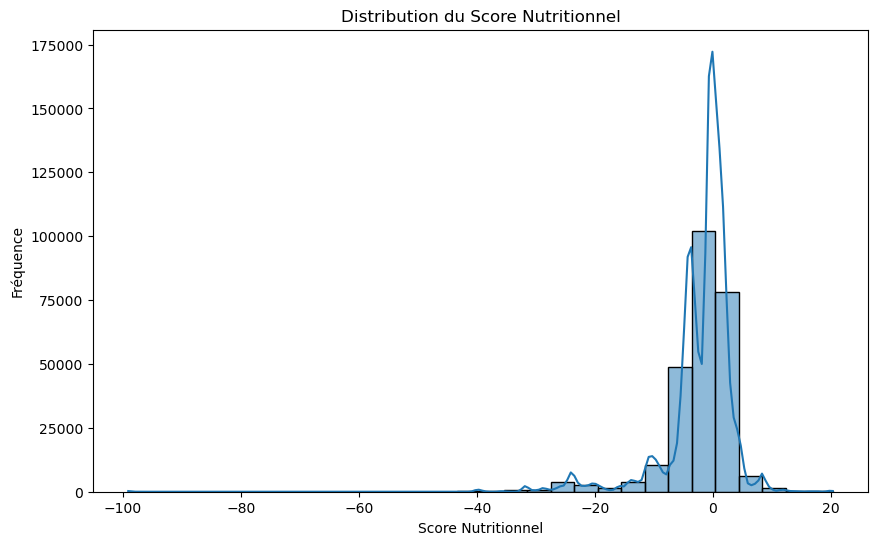

In [123]:
plt.figure(figsize=(10, 6))
sns.histplot(pd_transformed['nutrition_score'].dropna(), bins=30, kde=True)
plt.title('Distribution du Score Nutritionnel')
plt.xlabel('Score Nutritionnel')
plt.ylabel('Fréquence')
plt.show()


/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 3639 (\N{THAI CHARACTER SARA UEE}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:17

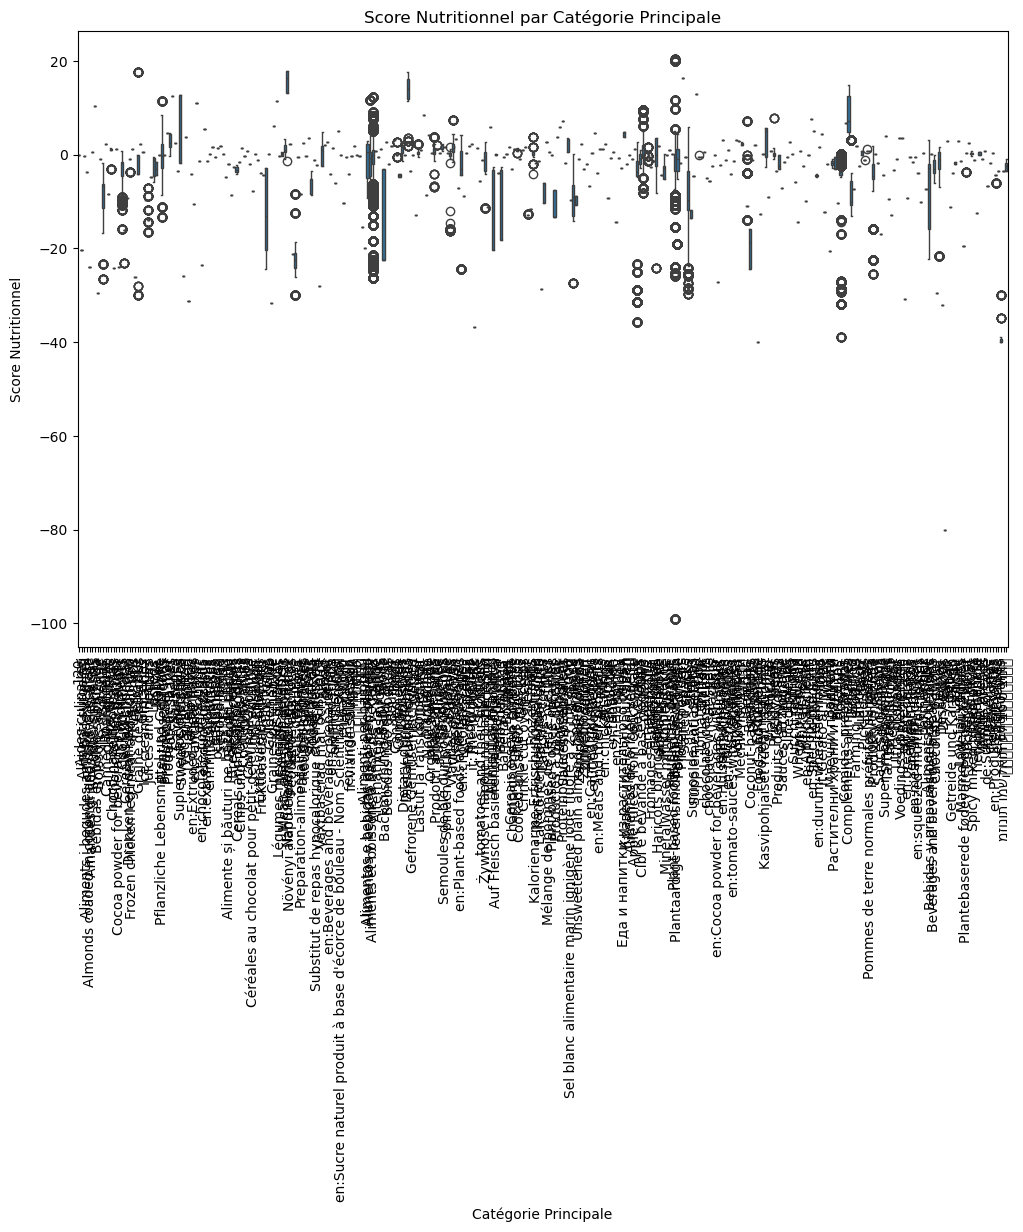

In [124]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='main_category', y='nutrition_score', data=pd_transformed)
plt.title('Score Nutritionnel par Catégorie Principale')
plt.xlabel('Catégorie Principale')
plt.ylabel('Score Nutritionnel')
plt.xticks(rotation=90)
plt.show()


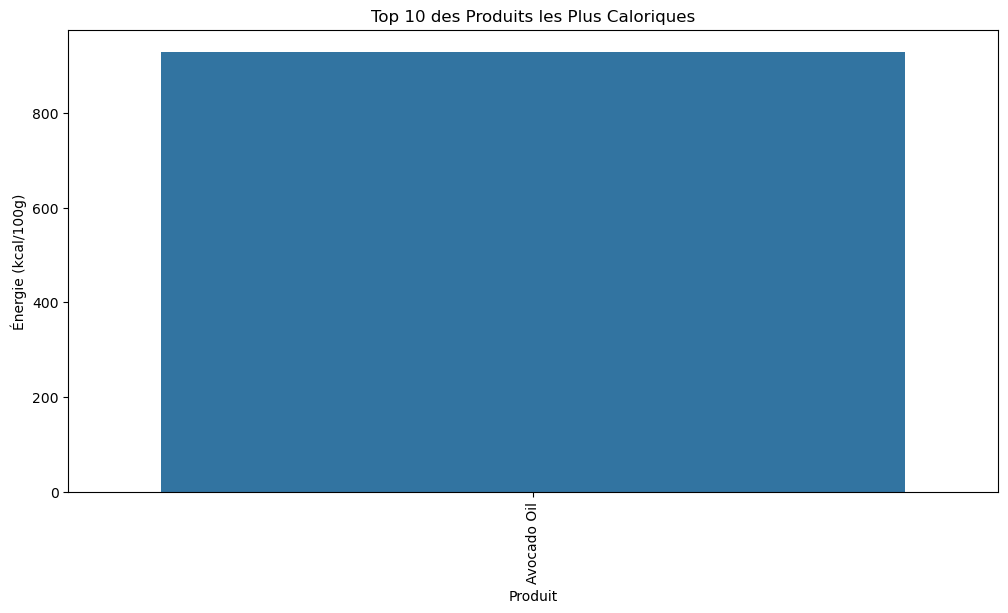

In [125]:
# Sélectionner les top produits les plus caloriques
top_caloric_products = pd_transformed.sort_values('energy-kcal_100g', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='product_name', y='energy-kcal_100g', data=top_caloric_products)
plt.title('Top 10 des Produits les Plus Caloriques')
plt.xlabel('Produit')
plt.ylabel('Énergie (kcal/100g)')
plt.xticks(rotation=90)
plt.show()


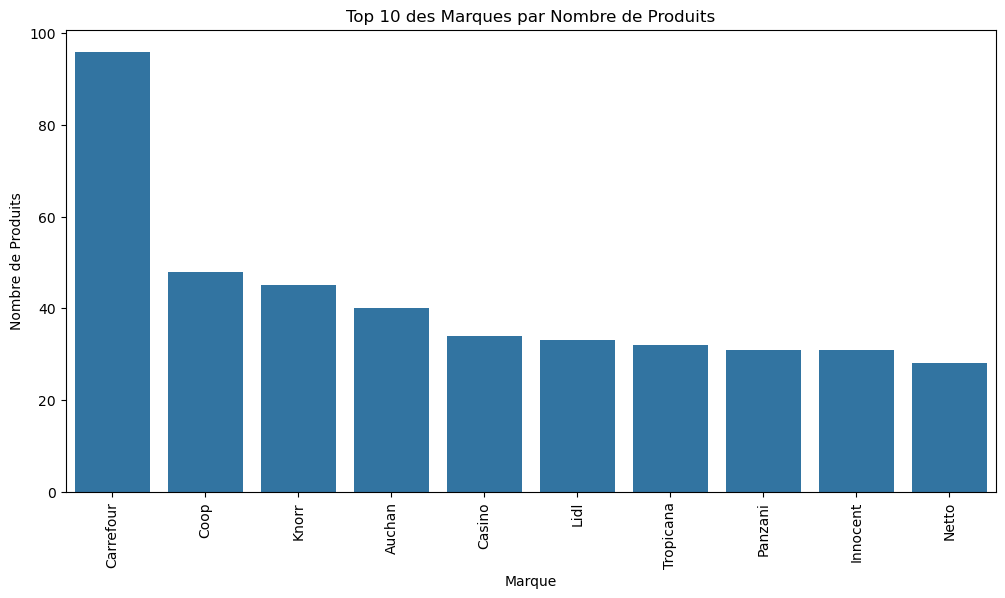

In [109]:
top_brands = pd_transformed['brands'].value_counts().head(10).reset_index()
top_brands.columns = ['brands', 'product_count']

plt.figure(figsize=(12, 6))
sns.barplot(x='brands', y='product_count', data=top_brands)
plt.title('Top 10 des Marques par Nombre de Produits')
plt.xlabel('Marque')
plt.ylabel('Nombre de Produits')
plt.xticks(rotation=90)
plt.show()


/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 32431 (\N{CJK UNIFIED IDEOGRAPH-7EAF}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 29275 (\N{CJK UNIFIED IDEOGRAPH-725B}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 22902 (\N{CJK UNIFIED IDEOGRAPH-5976}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ETL_project/lib/python3.10/site-packages/IPython/core/

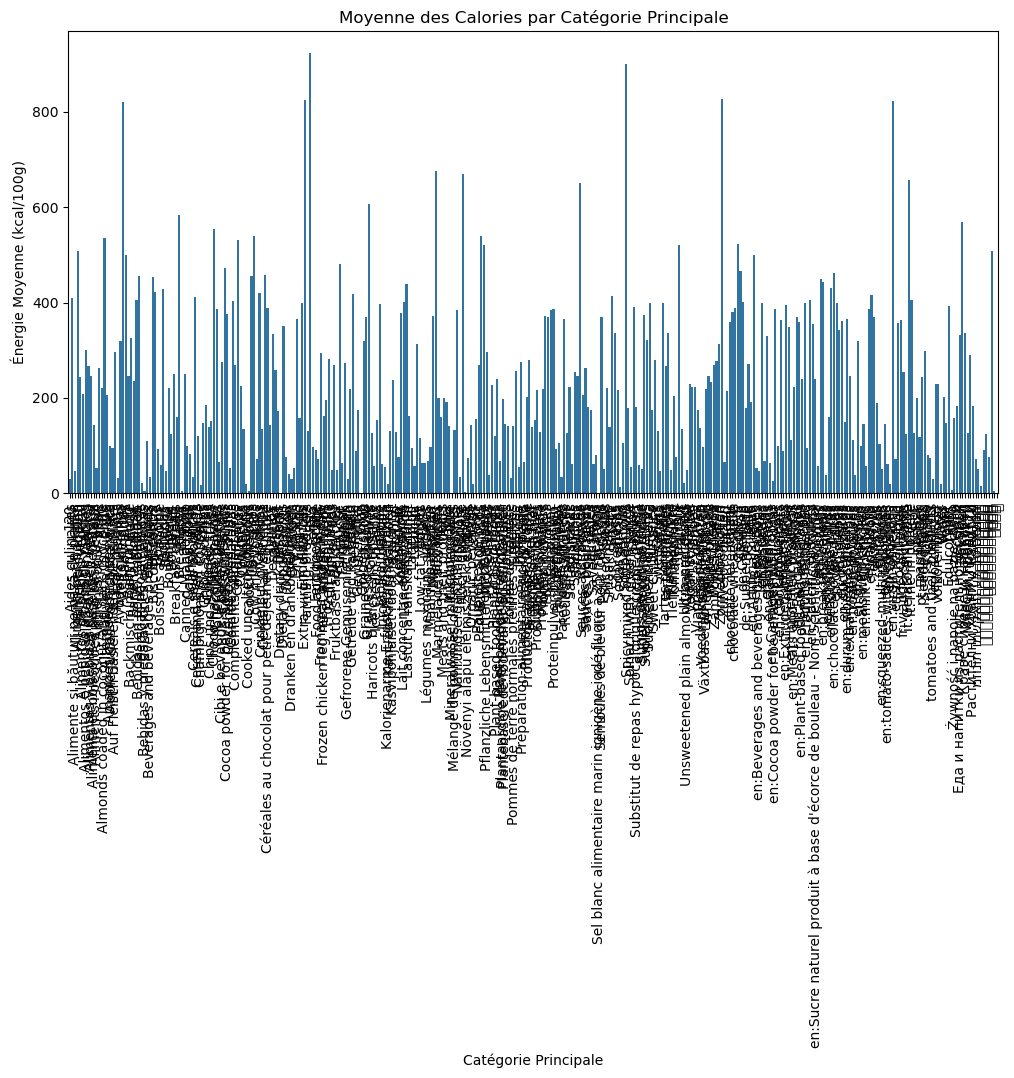

In [126]:
# Calculer les moyennes
nutrient_means = pd_transformed.groupby('main_category').agg({
    'energy-kcal_100g': 'mean',
    'fat_100g': 'mean',
    'proteins_100g': 'mean',
    'sugars_100g': 'mean',
    'salt_100g': 'mean'
}).reset_index()

# Visualiser la moyenne des calories par catégorie
plt.figure(figsize=(12, 6))
sns.barplot(x='main_category', y='energy-kcal_100g', data=nutrient_means)
plt.title('Moyenne des Calories par Catégorie Principale')
plt.xlabel('Catégorie Principale')
plt.ylabel('Énergie Moyenne (kcal/100g)')
plt.xticks(rotation=90)
plt.show()


In [111]:
fig = px.box(pd_transformed, x='main_category', y='nutrition_score', title='Score Nutritionnel par Catégorie Principale')
fig.update_layout(xaxis_title='Catégorie Principale', yaxis_title='Score Nutritionnel')
fig.show()


In [112]:
# Statistiques descriptives générales
stats_desc = pd_transformed.describe()
print(stats_desc)


           quantity  energy-kcal_100g     fat_100g  saturated-fat_100g  \
count  1.610000e+02       6510.000000  6948.000000         6685.000000   
mean   1.092000e+11        230.001096    10.409341            3.135103   
std    9.830021e+11        194.996689    21.931484            5.779892   
min    7.300000e+02          0.000000     0.000000            0.000000   
25%    8.000000e+02         68.000000     0.600000            0.100000   
50%    1.000000e+03        180.000000     3.300000            1.000000   
75%    3.051000e+03        357.000000    11.000000            3.800000   
max    9.788577e+12       2000.000000   938.800000           94.800000   

       proteins_100g    salt_100g  nutriscore_score  sodium_100g  sugars_100g  \
count    6939.000000  6403.000000       4743.000000  6403.000000  6797.000000   
mean        8.216042     1.614775          5.283576     0.645726    10.526369   
std        13.108233    22.246645          8.029858     8.896466    17.074517   
min      